In [ ]:

import matlab.engine
import matlab
eng = matlab.engine.start_matlab()
import sys
from matplotlib.colors import Normalize
from matplotlib import cm
from calculate_k_b import Calibration_mass
import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.interpolate as spi
import obspy
from obspy.signal.detrend import polynomial
import matplotlib
from matplotlib import pyplot as plt
matplotlib.use('TkAgg')
import h5py
import pathlib as pl
import os
import pickle
import array
#from pynufft import NUFFT

my_path = os.path.abspath(r"C:\Users\user\Desktop\Data_newTOF")


# font = {
#        'size'   : 35}
#mpl.rc('font', **font)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"],
#     'font.size': 22})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
#     'font.size': 22
# })

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def save_obj(obj, filename):
    with open(filename, 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

class FFT_ionS():
    def __init__(self, filename, massRange=[5, 50], dcRange=200, cal_mass=[17,18], cal_pixel=[1,65]):
        '''

        '''
        
        self.filename, self.massDictFile, self.interSpecFile, self.interSpecFile2, self.FFTdictFile, self.SFTdictFile, self.delayFile, self.delayDictFile = filename
        self.channelSize = 128
        self.scanLength = 248000
        self.peakRange = [-15, 15]  # range of the peak
        self.delay = (np.arange(self.scanLength)-self.scanLength/2)/self.scanLength*(413.7/415)*207*2*3.33564*10**-15 #308.7 um is the whole range
        #428
        self.delay_wp = {}

        self.rebin_delay = None
        self.ifrebin = False
        self.longstage = True
        self.data = 0
        self.massRange = massRange
        self.dcRange = dcRange
        self.windowSize = 100
        self.calculator = Calibration_mass(cal_mass, cal_pixel)
        self.gasBottle = {
            #"43": self.calculator.cal_pixel(43) + self.peakRange,
            #"45": self.calculator.cal_pixel(45) + self.peakRange,
            #"58": self.calculator.cal_pixel(58) + self.peakRange,
            #"CH3OH+": self.calculator.cal_pixel(32) + self.peakRange,
            #"CH2OH+": self.calculator.cal_pixel(31) + self.peakRange,
            #"CHOH+": self.calculator.cal_pixel(30) + self.peakRange,
            #"CHO+": self.calculator.cal_pixel(29) + self.peakRange,
            #"CO+":self.calculator.cal_pixel(28) +self.peakRange,
            #"CH2+":self.calculator.cal_pixel(14) +self.peakRange,
            #"CH3+":self.calculator.cal_pixel(15) +self.peakRange,
            # "N": self.calculator.cal_pixel(14) +self.peakRange,
            # "O": self.calculator.cal_pixel(16)+self.peakRange,
            #"H2O+": self.calculator.cal_pixel(18)+self.peakRange,
            # "N2": self.calculator.cal_pixel(28)+self.peakRange,
            # "$O_2$": self.calculator.cal_pixel(32)+self.peakRange,
            # "N": self.calculator.cal_pixel(14) +self .peakRange,
            # "O": self.calculator.cal_pixel(16)+self.peakRange,
            "H2O+": self.calculator.cal_pixel(18)+self.peakRange,
            #"OH-": self.calculator.cal_pixel(17)+self.peakRange,
            # "N2": self.calculator.cal_pixel(28)+self.peakRange,
            # "O2": self.calculator.cal_pixel(32)+self.peakRange,
            # "Ar": self.calculator.cal_pixel(32)+self.peakRange,
            #"\'CH3OH+\'-\'CH2OH+\'":np.append(self.calculator.cal_pixel(43) + self.peakRange, self.calculator.cal_pixel(58) + self.peakRange),
            #"\'CH3OH+\'+\'CH2OH+\'": #[0,self.channelSize]
            #np.append(np.append(self.calculator.cal_pixel(17) + self.peakRange, self.calculator.cal_pixel(18) + self.peakRange),0),
        }
        self.massSpectraBottle = {}
        self.interSpectraBottle = {}
        self.interSpectraBottle2={}
        self.fftS = {}
        self.stftS = {}
        self.delayMonitor = {}
        self.spec = None
        self.scanNo = None
        self.evenMaxIndex = None
        self.oddMaxIndex = None

    def read_split(self):
        with h5py.File(self.filename, 'r') as f:
            print(np.array(f['ppNum']))
            print(f.keys())
            self.data =f['data']
            self.dataShape = f['data'].shape
            print(self.dataShape)
            #for i in range(self.dataShape[0]):
            for i in range(70):
                self.delayMonitor[i]=np.array(f['daq_readout_'+str(i)])
            save_obj(self.delayMonitor, self.delayDictFile)
            self.mass_spectra()
            print(load_obj(self.massDictFile)['H2O+'].keys())
            print(f['ppNum'])

    def mass_spectra(self):
        #indS = self.dataShape[2]-self.findOverlap()
        shiftOver=True
        indS=248000-11445
        iT = True#iT =True if self.evenMaxIndex>self.oddMaxIndex else False
        for gas in self.gasBottle.keys():
            self.massSpectraBottle[gas]={}
            for i in range(self.dataShape[0]):
                [pixelMin, pixelMax] = list(map(int, self.gasBottle[gas]))
                if i%2==0: # shift the delay direction of the no.2 4 6 8 ... scan.
                    self.massSpectraBottle[gas][i] = sum(
                        self.data[i,pixelMin:pixelMax, :], 0)
                    if shiftOver:
                        if iT:
                            self.massSpectraBottle[gas][i] = self.massSpectraBottle[gas][i][-indS:]
                        else:
                            self.massSpectraBottle[gas][i] = self.massSpectraBottle[gas][i][:indS]
                        self.delay = self.delay[:indS] #308.7 um is the whole range
                else:
                    self.massSpectraBottle[gas][i] = sum(
                        self.data[i,pixelMin:pixelMax, :], 0)
                    self.massSpectraBottle[gas][i] = self.massSpectraBottle[gas][i][::-1]
                    if shiftOver:
                        if iT:
                            self.massSpectraBottle[gas][i] = self.massSpectraBottle[gas][i][:indS]
                        else:
                            self.massSpectraBottle[gas][i] = self.massSpectraBottle[gas][i][-indS:]
        
        save_obj(self.massSpectraBottle, self.massDictFile)

    def findMax(self,spec):
        index = np.where(np.isclose(spec, max(spec)))
        return index[0][0]
    
    def findOverlap(self):
        self.evenMaxIndex = self.findMax(sum(sum([self.data[2] for i in range(10) if i%2==0])))
        self.oddMaxIndex = self.findMax(sum(sum([self.data[2] for i in range(10) if i%2==1])))
        return abs(self.evenMaxIndex-self.oddMaxIndex)

    def window(self, windowSize=0, direction='left'):
        '''
        windowSize is in fs.
        '''
        massSpectra = load_obj(self.massDictFile)
        for gas in massSpectra.keys():
            self.interSpectraBottle[gas]={}
            for i in massSpectra[gas].keys():
                self.interSpectraBottle[gas][i]={}
                if direction=='middle':
                    if 'rebin' not in gas:
                        self.interSpectraBottle[gas][i]['left'],self.interSpectraBottle[gas][i]['right'],self.delay_wp['left'],self.delay_wp['right']= self.inter_window(massSpectra[gas][i], self.delay, windowSize=windowSize, direction=direction)
                    else:
                        self.interSpectraBottle[gas][i]['left'], self.interSpectraBottle[gas][i]['right'], self.delay_wp['rebin_left'], self.delay_wp['rebin_right'] = self.inter_window(massSpectra[gas][i], self.rebin_delay, windowSize=windowSize, direction=direction)
                elif direction=='left' or direction=='right':
                    if 'rebin' not in gas:
                        self.interSpectraBottle[gas][i][direction],self.delay_wp[direction]= self.inter_window(massSpectra[gas][i], self.delay, windowSize=windowSize, direction=direction)
                    else:
                        self.interSpectraBottle[gas][i]['rebin_'+direction],self.delay_wp['rebin_'+direction] = self.inter_window(massSpectra[gas][i], self.rebin_delay, windowSize=windowSize, direction=direction)


        save_obj(self.interSpectraBottle, self.interSpecFile)
        save_obj(self.delay_wp, self.delayFile)
            
    def inter_window(self, data, delay, windowSize=0, direction='left'):
        '''
        windowSize is in fs.
        '''
        data = data
        __len = np.size(data)
        windowSize = int(windowSize/((delay[100]-delay[0])/100)*1e-15)

        if direction == 'left':
            window = data[-(__len-windowSize):]
            delay = delay[-(__len-windowSize):]
            return self.rmvExp(window), delay
        elif direction == 'right':
            window = data[:__len-windowSize]
            delay = delay[:__len-windowSize]
            return window, delay
        elif direction == 'middle':
            window_left=data[:int(__len/2)-windowSize]
            window_right=data[-(int(__len/2)-windowSize):]
            delay_left=delay[:int(__len/2)-windowSize]
            delay_right=delay[-(int(__len/2)-windowSize):]
            return self.rmvExp(window_left), self.rmvExp(window_right), delay_left, delay_right
            #window = np.concatenate((
            #    data[:round((__len-windowSize)/2)],  # need to check again
            #    (data[round((__len-windowSize)/2)] + \
            #     data[round((__len+windowSize)/2)])/2*(np.zeros(windowSize)+1),
            #    data[-(__len-round((__len+windowSize)/2)+1):]
            #))
            #self.paddedDelay = np.arange(self.delay[0])
        # if (stepNum_left%2) == 0:
        #    paddingWindow = np.concatenate(( np.zeros(int(stepNum_left/2))+1,
        #    np.zeros(windowSize*2),np.zeros(int(stepNum_left/2))+1,np.zeros(paddingSize)))
        #    #self.paddedDelay = np.arange(self.delay[0])
        # else:
        #    paddingWindow = np.concatenate((np.zeros(paddingSize), np.zeros(int((stepNum_left-1)/2))+1,
        #    np.zeros(windowSize*2),np.zeros(int((stepNum_left+1)/2))+1, np.zeros(paddingSize)))
            # plt.plot(dcShift)
        

    def padding(self, paddingSize=0):
        interSpectra=load_obj(self.interSpecFile)
        self.delay_wp = load_obj(self.delayFile)
        for gas in interSpectra.keys():
            self.interSpectraBottle2[gas]={}
            for i in interSpectra[gas].keys():
                self.interSpectraBottle2[gas][i]={}
                for key in interSpectra[gas][i].keys():
                    if "rebin" not in gas:
                        self.interSpectraBottle2[gas][i][key], self.delay_wp[key] = self.inter_padding(interSpectra[gas][i][key], self.delay_wp[key], paddingSize = paddingSize)
                    else:
                        self.interSpectraBottle2[gas][i]["rebin"+key], self.delay_wp["rebin"+key] = self.inter_padding(interSpectra[gas][i][key], self.delay_wp[key], paddingSize = paddingSize)
        save_obj(self.interSpectraBottle2, self.interSpecFile2)
        save_obj(self.delay_wp, self.delayFile)

    def inter_padding(self, spec, delay, paddingSize=0):
        delayStep = delay[1]-delay[0]
        delay = np.concatenate((
            np.arange(delay[0]-(paddingSize+1) *
                      delayStep, delay[0], delayStep),
            delay,
            np.arange(delay[-1]+delayStep, delay[-1] +
                      (paddingSize)*delayStep, delayStep)
        ))
        inter_data = spec
        data = np.concatenate(
            ((np.zeros(paddingSize)), inter_data, (np.zeros(paddingSize))), axis=0)
        delay = delay[:len(data)]
        return data, delay

    def interpS(self, interNum=1):
        interpDelay = np.arange(
            self.delay[0], self.delay[-1], (self.delay[1]-self.delay[0])/(interNum+1))
        for gas in self.spectraBottle.keys():
            iS = np.interp(interpDelay, self.delay, self.spectraBottle[gas])
            self.spectraBottle[gas] = iS
            # print(np.shape(iS))
        self.delay = interpDelay
        # print(np.sie(self.delay))

    def FFT(self, t, y):
        n = len(t)
        delta = (max(t) - min(t)) / (n-1)
        k = int(n/2)
        f = np.arange(k) / (n*delta) / 10**12  # frequency unit THz
        Y = sp.fft.fft(y)[:k]
        return np.array([f, Y])
    
    def FFTS(self):
        interSpectra = load_obj(self.interSpecFile2)
        delay = load_obj(self.delayFile)
        for gas in interSpectra.keys():
            self.fftS[gas] = {}
            for i in interSpectra[gas].keys():
                self.fftS[gas][i] = {}
                for key in interSpectra[gas][i]:
                    if self.ifrebin:
                        if "rebin" not in gas:
                            continue
                        else:
                            delay = self.rebin_delay
                            self.fftS[gas][i][key] = self.FFT(
                                delay[key], interSpectra[gas][i][key])
                    else:
                        if "rebin" not in gas:
                            self.fftS[gas][i][key] = self.FFT(
                                delay[key], interSpectra[gas][i][key])
                        else:
                            continue
        save_obj(self.fftS, self.FFTdictFile)
    # def filterS(self, band):
     #   for gas in self.spectraBottle.keys():
      #      N, wn = sps.buttord(1e11, )
       #     fil = sps.butter(10, band, btype='band', fs=1000, output='sos')
        #    self.spectraBottle[gas] = sps.sosfilt(fil, self.spectraBottle[gas])

    def STFTS(self, windowsize=0, ratio=10):
        '''
        windowsize is window size in fs
        '''
        for gas in self.spectraBottle.keys():
            #if 'rebin' not in gas or 'filter' not in gas:
            if 'rebin' not in gas:
                continue
            f, t, self.stftS[gas] = sps.stft(self.spectraBottle[gas], fs=1/(
                self.rebin_delay[2]-self.rebin_delay[1]), noverlap=windowsize-2, nperseg=windowsize, nfft=windowsize*3)
            #self.stftS[gas] = self.stftS[gas][:,::-1]*10
            self.stftS[gas] = self.stftS[gas]*10
            vmax=abs(self.stftS[gas][:int(len(f)/15)]).max()
            vmin=abs(self.stftS[gas]).min()
            norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
            levels = np.arange(vmin,vmax,(vmax-vmin)/500)
            plt.figure(figsize=(8.0, 5.0))
            plt.contourf(t*10**15+120, f/10**12*33.35641,
                           np.abs(self.stftS[gas]), levels=levels, cmap='jet', norm=norm)
            #plt.xlim([100, self.delay[-1]])
            plt.ylim([0, 5000])
            plt.ylabel('Frequency [cm-1]')
            plt.xlabel('Time [fs]')
            plt.clim(0,abs(self.stftS[gas][:int(len(f)/15)]).max())
            plt.colorbar(ticks=levels[::100])
            d = '_120_160'
            plt.title(gas+d)
            plt.tight_layout()
            plt.savefig("good"+str(windowsize),dpi=720, bbox_inches='tight', pad_inches=0.2)
            plt.show()

    def rmvExp(self,data):
        return polynomial(data, order=3, plot=False)

    def runingAverage(self, n=5):
        def runAve(x, N): return np.convolve(x, np.ones(N)/N, mode='valid')
        for gas in self.spectraBottle.keys():
            self.spectraBottle[gas] = runAve(self.spectraBottle[gas], n)
            new_size = len(self.spectraBottle[gas])
        self.delay = self.delay[:new_size]

    def smooth(self, windowSize=100, order=3):
        for gas in self.spectraBottle.keys():    
            self.spectraBottle[gas]=sps.savgol_filter(self.spectraBottle[gas], windowSize, order) # window size 51, polynomial order 3
    
    def rebin_factor(self, a, factor):
            '''Rebin an array to a new shape.
            newshape must be a factor of a.shape.
            '''
            newshape = tuple(int(i/factor) for i in a.shape)
            i1 = tuple(int(i*factor) for i in newshape)
            a = a[:i1[0]]
            return a.reshape(newshape+(-1,)).mean(axis=-1)
    
    def rebinS(self, factor=10):
        self.ifrebin = True
        for gas in list(self.spectraBottle.keys()):
            self.spectraBottle['rebin_'+gas] = self.rebin_factor(self.spectraBottle[gas], factor)
        self.rebin_delay = self.rebin_factor(self.delay, factor)

    def show_FFT(self,side):
        fftSpectra = load_obj(self.FFTdictFile)
        fig=plt.figure()
        even_list=[]
        odd_list=[]
        for gas in fftSpectra.keys():
            for i in fftSpectra[gas].keys():
                if i%2 == 0:
                    even_list.append(i)
                else:
                    odd_list.append(i)
            #[f, Y] = np.abs(sum(fftSpectra[gas][i]['right'] for i in even_list))+np.abs(sum(fftSpectra[gas][i]['right'] for i in odd_list))
            [f, Y] = np.real(sum(fftSpectra[gas][i][side] for i in fftSpectra[gas].keys() if i%2==0))#+np.real(sum(fftSpectra[gas][i][side] for i in fftSpectra[gas].keys() if i%2==1))
            f = fftSpectra[gas][0][side][0]
            ax = fig.add_subplot(1,1,1)
            ax.plot(f[self.dcRange:]*33.35641, np.abs(Y[self.dcRange:]), label=gas)
            ax.set_xlabel('Frequency/cm-1')
            ax.set_ylabel('a.u.')
            ax.legend((gas,))
            #ax.set_ylim([0,np.max(Y[self.dcRange:1000])*3/2])
            ax.set_xlim([0,20000])
        plt.tight_layout()
        d='_70_90'
        plt.title('FFT[100:600]'+d)
        #plt.savefig("fft_31"+d,dpi=720, bbox_inches='tight', pad_inches=0.2)

        # plt.figure()
        # for gas in ['N', 'O']:
        #    [f, Y] = self.fftS[gas]
        #    plt.plot(f[self.dcRange:], Y[self.dcRange:], label=gas)
        #    plt.xlabel('THz')
        #    plt.ylabel('a.b.')
        #    plt.legend(gas)
        # plt.legend()
        plt.show()

    def show_Spectra(self, side, shift=0):
        #interSpectra = load_obj(self.interSpecFile)
        interSpectra = load_obj(self.interSpecFile2)
        delay = load_obj(self.delayFile)
        for gas in interSpectra.keys():

            if 'rebin' not in gas: #or 'filter' not in gas:
            #if 'filter' not in gas:
             #   continue
            #elif 'rebin' not in gas:
                delay = delay[side]
            else:
                delay = self.rebin_delay
            spec = sum([interSpectra[gas][i][side] for i in interSpectra[gas].keys()])
            print(sum(interSpectra[gas][5][side]),sum(interSpectra[gas][6][side]),sum(interSpectra[gas][7][side]))
            plt.plot(delay*10**15+shift, spec, label=gas)
            #plt.plot(np.arange(len(self.delay)), spec, label=gas)

        plt.show()
        #plt.savefig("spectra_31"+d,dpi=720, bbox_inches='tight', pad_inches=0.2)

    def dataProcess(self):
        # self.mass_spectra()
        self.FFTS()

    # def filter(self, lowcut, highcut, fs, order=5):
    #     #b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
    #     #w, h = sps.freqz(b, a, worN=2000)

    #     sos = self.butter_bandpass(lowcut, highcut, fs, order=order)
    #     w, h = sps.sosfreqz(sos, worN=2000)

    def useFilter(self, lowcut, highcut):
        for gas in list(self.spectraBottle.keys()):
            # if 'rebin' not in gas:
            fs = 1/(self.delay[90]-self.delay[89])
            # else:
            #     fs = 1/(self.rebin_delay[90]-self.rebin_delay[89])
            self.spectraBottle['filter_'+gas] = self.butter_bandpass_filter(self.spectraBottle[gas], lowcut, highcut, fs)

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = sps.butter(order, [low, high], analog=False, btype='band', output='sos')
        y = sps.sosfiltfilt(sos, data)
        #w, h = sps.sosfreqz(sos, worN=2000)
        #plt.plot(w, h)
        #plt.show()
        return y

class FFTOSC(FFT_ionS):
    def __init__(self, delay, data, massRange=[31, 32], dcRange=2, label=None):
        super().__init__(delay, data, massRange=massRange, dcRange=dcRange, label=label)

    def mass_spectra(self):
        self.spectraBottle['CH3OH+'] = self.data
 
        

In [ ]:

    yearAndMonth = r'2021-10'
    date, filename = [r'2021-10-10', r'scan_tof_2021-10-10-22-28-56']
    if 'linux' in sys.platform:
        dataPath = r'/mnt/c/Users/user/Desktop/Data_newTOF'
        dataPath = pl.PurePath(dataPath)
    else:
        dataPath = r'C:\Users\user\Desktop\Data_newTOF'
        dataPath = pl.PureWindowsPath(dataPath)
    
    if not os.path.exists(os.path.join(dataPath, yearAndMonth, date, filename)):
        os.mkdir(os.path.join(dataPath, yearAndMonth, date, filename))
    dataFile =  os.path.join(dataPath, yearAndMonth, date, filename+r'.hdf5')
    massDictFile = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_massDict'+r'.pkl')
    interSpecDictFile = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_interSpec'+r'.pkl')
    interSpecDictFile2 = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_interSpec2'+r'.pkl')
    FFTdictFile = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_FFTdict'+r'.pkl')
    SFTdictFile = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_SFTdict'+r'.pkl')
    delayFile = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_delay'+r'.pkl')
    delayDictFile = os.path.join(dataPath, yearAndMonth, date, filename, filename+r'_delayDict'+r'.pkl')
    files = [dataFile, massDictFile, interSpecDictFile, interSpecDictFile2, FFTdictFile, SFTdictFile, delayFile, delayDictFile]
    

    x = FFT_ionS(filename=files, dcRange=30, massRange=[5,50])

    #print(dataPath)
    #x.read_split()
    side = 'right'
    x.window(windowSize=200, direction=side)
    x.padding(paddingSize=00000)
    #x.show_Spectra(side)
    #x.FFTS()
    #x.show_FFT(side)
    delayMonitor = load_obj(x.delayDictFile)
    delayMonitor_d = np.array(delayMonitor[1],dtype=float)
    #delayMonitor_m = matlab.double(array.array('d',np.nditer(delayMonitor_d)))
    delayMonitor_m = matlab.double(delayMonitor_d.tolist())
    eng.workspace['y'] = delayMonitor_m
    #print(delayMonitor_m)
    #delayMonitor_m = eng.real(delayMonitor_m)
    delayMonitor_m = np.array(eng.eval('fmdemod(y,1.5,1000,1)'))



KeyboardInterrupt: 

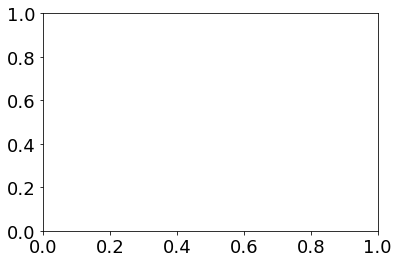

In [24]:
import pylab
#delayMonitor_m = eng.fmdemod(delayMonitor_m,1.5,1000,1)
pylab.plot(delayMonitor_m)
#plt.show()